In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, validation_curve, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

## Load Data

In [3]:
data = load_breast_cancer()
x = data.data
y = data.target
print(data.feature_names)
print(f"{x.shape=}")
print("y:", np.unique(y, return_counts=True))

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
x.shape=(569, 30)
y: (array([0, 1]), array([212, 357], dtype=int64))


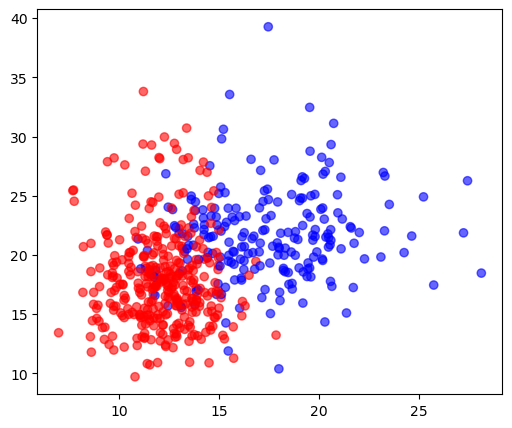

In [4]:
plt.figure(figsize=(6,5))
plt.scatter(x[:,0], x[:,1], c=y, alpha=0.6, cmap="bwr")
plt.show()

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

print(f"{x_train.shape = }")
print(f"{x_test.shape = }")
print(f"{y_train.shape = }")
print(f"{y_test.shape = }")

x_train.shape = (284, 30)
x_test.shape = (285, 30)
y_train.shape = (284,)
y_test.shape = (285,)


In [6]:
model = KNeighborsClassifier(n_neighbors=50)
model.fit(x_train, y_train)

train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print(f"{train_accuracy=}")
print(f"{test_accuracy=}")

train_accuracy=0.8908450704225352
test_accuracy=0.9298245614035088


## Evaluation par validation Croissée

In [7]:
k_score = {}
for k in range(1, 50):
    
    model = KNeighborsClassifier(n_neighbors = k)

    cv_score = cross_val_score(
        estimator = model,
        X = x_train,
        y = y_train,
        cv = 5,
        scoring = "accuracy" 
    )
    
    k_score[k] = cv_score.mean()


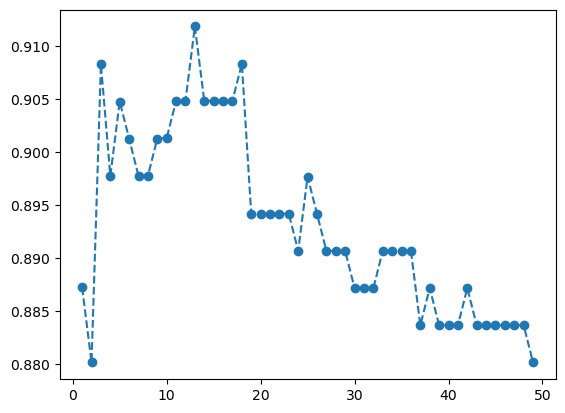

In [8]:
plt.plot(k_score.keys(), k_score.values(), 'o--')
plt.show()

In [9]:
train_scores, validation_scores = validation_curve(estimator=model,
                                                   X=x_train,
                                                   y=y_train,
                                                   cv=5,
                                                   param_name="n_neighbors",
                                                   param_range=range(1, 50),
                                                   scoring="accuracy")

In [10]:
train_scores.shape

(49, 5)

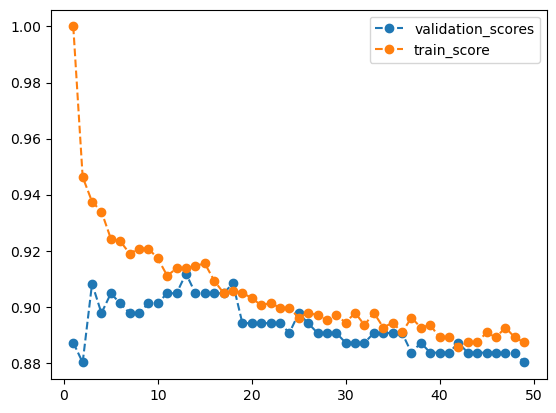

In [11]:
mean_score = validation_scores.mean(axis=1)

plt.plot(range(1,50), mean_score, "o--", label='validation_scores')
plt.plot(range(1,50), train_scores.mean(axis=1), "o--", label='train_score')
plt.legend()
plt.show()

### Optimisation de plusieurs hyper-parametre avec GridSearch

In [12]:
param_grid = {"n_neighbors" : range(1,20),
              "metric": ["minkowski","cosine", "euclidean"]
}

grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring="accuracy")

grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=49),
             param_grid={'metric': ['minkowski', 'cosine', 'euclidean'],
                         'n_neighbors': range(1, 20)},
             scoring='accuracy')

In [13]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_metric', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [14]:
params = grid_search.cv_results_["params"]
scores = grid_search.cv_results_["mean_test_score"]

grid_search_results = pd.DataFrame(params)
grid_search_results["score"] = scores

grid_search_results.head()

,metric,n_neighbors,score
0,minkowski,1,0.887218
1,minkowski,2,0.880138
2,minkowski,3,0.908271
3,minkowski,4,0.897744
4,minkowski,5,0.904762


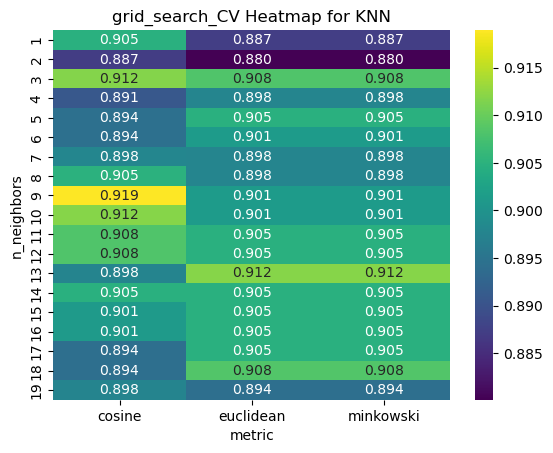

In [15]:
grid_search_heatmap = grid_search_results.pivot(index='n_neighbors', columns='metric', values='score')
sns.heatmap(grid_search_heatmap, cmap="viridis", fmt=".3f", annot=True)
plt.title("grid_search_CV Heatmap for KNN")
plt.show()

In [16]:
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleurs score : {grid_search.best_score_:.5f}")

Meilleurs paramètres : {'metric': 'cosine', 'n_neighbors': 9}
Meilleurs score : 0.91892


In [17]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

test_accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy sur le test : {test_accuracy}")

Accuracy sur le test : 0.9368421052631579
